* Stage 1 - You should submit predicted probabilities for every possible matchup in the past 5 NCAA® tournaments (2015-2019).
    * Due by March 13

* Stage 2 - You should submit predicted probabilities for every possible matchup before the 2021 tournament begins.
    * Due by March 19



In [44]:
%autoreload 2
%load_ext autoreload
from helper_functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# teams data
file_path = '../MarchMadness2021/data/MTeams.csv'
teams = load_dataframe(file_path)
teams.limit(5).toPandas()

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2021
1,1102,Air Force,1985,2021
2,1103,Akron,1985,2021
3,1104,Alabama,1985,2021
4,1105,Alabama A&M,2000,2021


### Questions about Teams data
1. Which teams have been in D1 longest, shortest period of time?
2. Which teams joined in 2021?
3. How has the number of teams in D1 increased year to year?

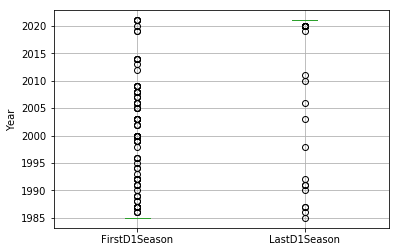

In [3]:
# Lets look at simple plots
teams \
    .select(col('FirstD1Season').cast(IntegerType())
            , col('LastD1Season').cast(IntegerType())) \
    .toPandas().boxplot()
plt.ylabel('Year')
plt.show()

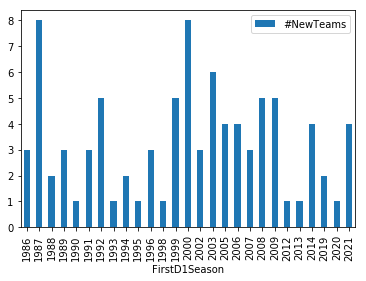

In [5]:
# number of teams joining D1 each year
teams.groupby('FirstD1Season').count() \
     .withColumnRenamed('count', '#NewTeams') \
     .filter(col('FirstD1Season') != 1985) \
     .orderBy('FirstD1Season') \
     .toPandas().plot('FirstD1Season', '#NewTeams', kind='bar')
plt.show()

* Takeaways:
    * D1 league start date in data is 1985
    * Lots of teams got into the league in 1985-1995 and not much new entry after 2010.
    * Total maximum number of years is 37 years including the current year.
* Data is partial and doesn't fully reflect historical data. 

In [7]:
# newbies in 2021
teams.filter(col('FirstD1Season') == 2021).toPandas()

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1468,Bellarmine,2021,2021
1,1469,Dixie St,2021,2021
2,1470,Tarleton St,2021,2021
3,1471,UC San Diego,2021,2021


In [8]:
# create feature Number of years in D1
teams = teams.withColumn('Years_D1', 1+col('LastD1Season') - col('FirstD1Season'))

### Questions about Seasons data
* What month did the season start?

In [13]:
# seasons data
file_path = '../MarchMadness2021/data/MSeasons.csv'

seasons = load_dataframe(file_path) \
                .withColumn('DayZero', to_date('DayZero', 'MM/dd/yyyy')) \
                .withColumn('DayZero', to_timestamp(col('DayZero'))) \
                .withColumn('Date', date_format(col('DayZero'), "d MMM")) 
                
seasons.limit(5).toPandas()

,Season,DayZero,RegionW,RegionX,RegionY,RegionZ,Date
0,1985,1984-10-29,East,West,Midwest,Southeast,29 Oct
1,1986,1985-10-28,East,Midwest,Southeast,West,28 Oct
2,1987,1986-10-27,East,Southeast,Midwest,West,27 Oct
3,1988,1987-11-02,East,Midwest,Southeast,West,2 Nov
4,1989,1988-10-31,East,West,Midwest,Southeast,31 Oct


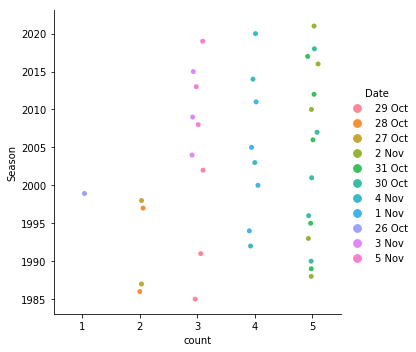

In [14]:
# between 26-November
seasons_df = seasons.groupby('Date').count().join(seasons, on='Date', how='right') \
                   .select(col('Season').cast(IntegerType())
                           , 'Date', col('count').cast(IntegerType())) \
                   .toPandas()


sns.catplot(x='count', y='Season', hue='Date', data=seasons_df)
plt.show()

* Takeaway: late october and first week of november is when college students check out their peers on the court :)

In [313]:
# lets combine these teams and teams dataframes
# seasons.select('Season', 'DayZero', )teams.select('TeamID', 'TeamName', 'num_years_D1')

### Tourney Seeds

In [15]:
# this will be useful to extract each seed of teams 
file_path = '../MarchMadness2021/data/MNCAATourneySeeds.csv'
tourney_seed = load_dataframe(file_path)
tourney_seed.limit(5).toPandas()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


* I have chosen to take a look at the detailed results instead of compact data because of it has more information and includes all of the compact results as well

### Season Detailed Results

In [143]:
file_path = '../MarchMadness2021/data/MRegularSeasonDetailedResults.csv'
detailed_season = load_dataframe(file_path)
# making sure all the data types with the exception of WLoc is an integer type
cols = [column for column in detailed_season.columns if column != 'WLoc']

detailed_season = \
reduce(lambda data, col_: data.withColumn(col_, col(col_).cast(IntegerType())), cols, detailed_season)

detailed_season.limit(5).toPandas()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


In [184]:
# lets create some obvious features and we will explore the data after
detailed_season = detailed_season.withColumn('Win_by', col('WScore') - col('LScore')) \
                                   .withColumn('Loss_by', -1 * col('Win_by'))

# split winning details
win_cols = ['Season'] + find_columns('W', detailed_season)

winner_detailed = detailed_season.select(win_cols) \
                                    .withColumn('HomeWin', when(col('WLoc') == 'H', 1).otherwise(0)) \
                                    .withColumn('AwayWin', when(col('WLoc') == 'A', 1).otherwise(0)) \
                                    .withColumn('NeutralWin', when(col('WLoc') == 'N', 1).otherwise(0)) 


# split losing details
loss_cols = ['Season'] + find_columns('L', detailed_season)

loss_detailed = detailed_season.select(loss_cols) \
                                    .withColumn('HomeLoss', when(col('WLoc') == 'H', 1).otherwise(0)) \
                                    .withColumn('AwayLoss', when(col('WLoc') == 'A', 1).otherwise(0)) \
                                    .withColumn('NeutralLoss', when(col('WLoc') == 'N', 1).otherwise(0)) 

In [185]:
# lets create winning features
winner_detailed_season = \
    winner_detailed.groupby('Season', 'WTeamID') \
        .agg(sum(lit(1)).alias('NumWins'),
             sum(col('HomeWin')).alias('HomeWins'),
             sum(col('AwayWin')).alias('AwayWins'), 
             sum(col('NeutralWin')).alias('NeutralWins'),
             round(sum(col('Win_by')), 1).alias('WinDiff'),
             round(sum(when(col('WLoc') == 'H', col('Win_by')).otherwise(0)), 1).alias('WHomeBy'), 
             round(sum(when(col('WLoc') == 'A', col('Win_by')).otherwise(0)), 1).alias('WAwayBy'),
             round(sum(when(col('WLoc') == 'N', col('Win_by')).otherwise(0)), 1).alias('WNeutralBy'),
             round(sum(col('WScore')), 1).alias('WScore'),
             round(sum(when(col('WLoc') == 'H', col('WScore')).otherwise(0)), 1).alias('WHomeScore'),
             round(sum(when(col('WLoc') == 'A', col('WScore')).otherwise(0)), 1).alias('WAwayScore'),
             round(sum(when(col('WLoc') == 'N', col('WScore')).otherwise(0)), 1).alias('WNeutralScore'),
             round(sum(col('WFTA')), 1).alias('WFTA'),
             round(sum(when(col('WLoc') == 'H', col('WFTA')).otherwise(0)), 1).alias('WHomeFTA'), 
             round(sum(when(col('WLoc') == 'A', col('WFTA')).otherwise(0)), 1).alias('WAwayFTA'),
             round(sum(when(col('WLoc') == 'N', col('WFTA')).otherwise(0)), 1).alias('WNeutralFTA'),
             round(sum(col('WFTM')), 1).alias('WFTM'),
             round(sum(when(col('WLoc') == 'H', col('WFTM')).otherwise(0)), 1).alias('WHomeFTM'), 
             round(sum(when(col('WLoc') == 'A', col('WFTM')).otherwise(0)), 1).alias('WAwayFTM'),
             round(sum(when(col('WLoc') == 'N', col('WFTM')).otherwise(0)), 1).alias('WNeutralFTM'),
             round(sum(col('WFGM')), 1).alias('WFGM'),
             round(sum(when(col('WLoc') == 'H', col('WFGM')).otherwise(0)), 1).alias('WHomeFGM'), 
             round(sum(when(col('WLoc') == 'A', col('WFGM')).otherwise(0)), 1).alias('WAwayFGM'),
             round(sum(when(col('WLoc') == 'N', col('WFGM')).otherwise(0)), 1).alias('WNeutralFGM'),
             round(sum(col('WFGA')), 1).alias('WFGA'),
             round(sum(when(col('WLoc') == 'H', col('WFGA')).otherwise(0)), 1).alias('WHomeFGA'), 
             round(sum(when(col('WLoc') == 'A', col('WFGA')).otherwise(0)), 1).alias('WAwayFGA'),
             round(sum(when(col('WLoc') == 'N', col('WFGA')).otherwise(0)), 1).alias('WNeutralFGA'),
             round(sum(col('WFGM3')), 1).alias('WFGM3'),
             round(sum(when(col('WLoc') == 'H', col('WFGM3')).otherwise(0)), 1).alias('WHomeFGM3'), 
             round(sum(when(col('WLoc') == 'A', col('WFGM3')).otherwise(0)), 1).alias('WAwayFGM3'),
             round(sum(when(col('WLoc') == 'N', col('WFGM3')).otherwise(0)), 1).alias('WNeutralFGM3'),
             round(sum(col('WFGA3')), 1).alias('WFGA3'),
             round(sum(when(col('WLoc') == 'H', col('WFGA3')).otherwise(0)), 1).alias('WHomeFGA3'), 
             round(sum(when(col('WLoc') == 'A', col('WFGA3')).otherwise(0)), 1).alias('WAwayFGA3'),
             round(sum(when(col('WLoc') == 'N', col('WFGA3')).otherwise(0)), 1).alias('WNeutralFGA3'),
             round(sum(col('WOR')), 1).alias('WOR'),
             round(sum(when(col('WLoc') == 'H', col('WOR')).otherwise(0)), 1).alias('WHomeOR'), 
             round(sum(when(col('WLoc') == 'A', col('WOR')).otherwise(0)), 1).alias('WAwayOR'),
             round(sum(when(col('WLoc') == 'N', col('WOR')).otherwise(0)), 1).alias('WNeutralOR'),
             round(sum(col('WDR')), 1).alias('WDR'),
             round(sum(when(col('WLoc') == 'H', col('WDR')).otherwise(0)), 1).alias('WHomeDR'), 
             round(sum(when(col('WLoc') == 'A', col('WDR')).otherwise(0)), 1).alias('WAwayDR'),
             round(sum(when(col('WLoc') == 'N', col('WDR')).otherwise(0)), 1).alias('WNeutralDR'),
             round(sum(col('WStl')), 1).alias('WStl'),
             round(sum(when(col('WLoc') == 'H', col('WStl')).otherwise(0)), 1).alias('WHomeStl'), 
             round(sum(when(col('WLoc') == 'A', col('WStl')).otherwise(0)), 1).alias('WAwayStl'),
             round(sum(when(col('WLoc') == 'N', col('WStl')).otherwise(0)), 1).alias('WNeutralStl'),
             round(sum(col('WAst')), 1).alias('WAst'),
             round(sum(when(col('WLoc') == 'H', col('WAst')).otherwise(0)), 1).alias('WHomeAst'), 
             round(sum(when(col('WLoc') == 'A', col('WAst')).otherwise(0)), 1).alias('WAwayAst'),
             round(sum(when(col('WLoc') == 'N', col('WAst')).otherwise(0)), 1).alias('WNeutralAst'),
             round(sum(col('WTO')), 1).alias('WTO'),
             round(sum(when(col('WLoc') == 'H', col('WTO')).otherwise(0)), 1).alias('WHomeTO'), 
             round(sum(when(col('WLoc') == 'A', col('WTO')).otherwise(0)), 1).alias('WAwayTO'),
             round(sum(when(col('WLoc') == 'N', col('WTO')).otherwise(0)), 1).alias('WNeutralTO'),
             round(sum(col('WBlk')), 1).alias('WBlk'),
             round(sum(when(col('WLoc') == 'H', col('WBlk')).otherwise(0)), 1).alias('WHomeBlk'), 
             round(sum(when(col('WLoc') == 'A', col('WBlk')).otherwise(0)), 1).alias('WAwayBlk'),
             round(sum(when(col('WLoc') == 'N', col('WBlk')).otherwise(0)), 1).alias('WNeutralBlk'),
             round(sum(col('WPF')), 1).alias('WPF'),
             round(sum(when(col('WLoc') == 'H', col('WPF')).otherwise(0)), 1).alias('WHomePF'), 
             round(sum(when(col('WLoc') == 'A', col('WPF')).otherwise(0)), 1).alias('WAwayPF'),
             round(sum(when(col('WLoc') == 'N', col('WPF')).otherwise(0)), 1).alias('WNeutralPF'),
             ) \
        .withColumnRenamed('WTeamID', 'TeamID')

# lets check if there are null values
check_nulls(winner_detailed_season)

Dataframe has no null values


In [186]:
# create loss features
loss_detailed_season = \
loss_detailed.groupby('Season', 'LTeamID') \
        .agg(sum(lit(1)).alias('NumLoss'),
             sum(col('HomeLoss')).alias('LossHome'),
             sum(col('AwayLoss')).alias('LossAway'), 
             sum(col('NeutralLoss')).alias('LossNeutral'),
             round(sum(col('Loss_by')), 1).alias('LossDiff'),
             round(sum(when(col('WLoc') == 'H',  col('Loss_by')).otherwise(0)), 1).alias('LHomeBy'), 
             round(sum(when(col('WLoc') == 'A', col('Loss_by')).otherwise(0)), 1).alias('LAwayBy'),
             round(sum(when(col('WLoc') == 'N', col('Loss_by')).otherwise(0)), 1).alias('LNeutralBy'),
             round(sum(col('LScore')), 1).alias('LScore'),
             round(sum(when(col('WLoc') == 'H', col('LScore')).otherwise(0)), 1).alias('LAwayScore'),
             round(sum(when(col('WLoc') == 'A', col('LScore')).otherwise(0)), 1).alias('LHomeScore'),
             round(sum(when(col('WLoc') == 'N', col('LScore')).otherwise(0)), 1).alias('LNeutralScore'),                             
             round(sum(col('LFTA')), 1).alias('LFTA'),
             round(sum(when(col('WLoc') == 'H', col('LFTA')).otherwise(0)), 1).alias('LAwayFTA'), 
             round(sum(when(col('WLoc') == 'A', col('LFTA')).otherwise(0)), 1).alias('LHomeFTA'),
             round(sum(when(col('WLoc') == 'N', col('LFTA')).otherwise(0)), 1).alias('LNeutralFTA'),
             round(sum(col('LFGM')), 1).alias('LFGM'),
             round(sum(when(col('WLoc') == 'H', col('LFGM')).otherwise(0)), 1).alias('LHomeFGM'), 
             round(sum(when(col('WLoc') == 'A', col('LFGM')).otherwise(0)), 1).alias('LAwayFGM'),
             round(sum(when(col('WLoc') == 'N', col('LFGM')).otherwise(0)), 1).alias('LNeutralFGM'),
             round(sum(col('LFGA')), 1).alias('LFGA'),
             round(sum(when(col('WLoc') == 'H', col('LFGA')).otherwise(0)), 1).alias('LHomeFGA'), 
             round(sum(when(col('WLoc') == 'A', col('LFGA')).otherwise(0)), 1).alias('LAwayFGA'),
             round(sum(when(col('WLoc') == 'N', col('LFGA')).otherwise(0)), 1).alias('LNeutralFGA'),
             round(sum(col('LFGM3')), 1).alias('LFGM3'),
             round(sum(when(col('WLoc') == 'H', col('LFGM3')).otherwise(0)), 1).alias('LHomeFGM3'), 
             round(sum(when(col('WLoc') == 'A', col('LFGM3')).otherwise(0)), 1).alias('LAwayFGM3'),
             round(sum(when(col('WLoc') == 'N', col('LFGM3')).otherwise(0)), 1).alias('LNeutralFGM3'),
             round(sum(col('LFGA3')), 1).alias('LFGA3'),
             round(sum(when(col('WLoc') == 'H', col('LFGA3')).otherwise(0)), 1).alias('LHomeFGA3'), 
             round(sum(when(col('WLoc') == 'A', col('LFGA3')).otherwise(0)), 1).alias('LAwayFGA3'),
             round(sum(when(col('WLoc') == 'N', col('LFGA3')).otherwise(0)), 1).alias('LNeutralFGA3'),
             round(sum(col('LFTM')), 1).alias('LFTM'),
             round(sum(when(col('WLoc') == 'H', col('LFTM')).otherwise(0)), 1).alias('LAwayFTM'), 
             round(sum(when(col('WLoc') == 'A', col('LFTM')).otherwise(0)), 1).alias('LHomeFTM'),
             round(sum(when(col('WLoc') == 'N', col('LFTM')).otherwise(0)), 1).alias('LNeutralFTM'),
             round(sum(col('LOR')), 1).alias('LOR'),
             round(sum(when(col('WLoc') == 'H', col('LOR')).otherwise(0)), 1).alias('LAwayOR'), 
             round(sum(when(col('WLoc') == 'A', col('LOR')).otherwise(0)), 1).alias('LHomeOR'),
             round(sum(when(col('WLoc') == 'N', col('LOR')).otherwise(0)), 1).alias('LNeutralOR'),
             round(sum(col('LDR')), 1).alias('LDR'),
             round(sum(when(col('WLoc') == 'H', col('LDR')).otherwise(0)), 1).alias('LAwayDR'), 
             round(sum(when(col('WLoc') == 'A', col('LDR')).otherwise(0)), 1).alias('LHomeDR'),
             round(sum(when(col('WLoc') == 'N', col('LDR')).otherwise(0)), 1).alias('LNeutralDR'),
             round(sum(col('LAst')), 1).alias('LAst'),
             round(sum(when(col('WLoc') == 'H', col('LAst')).otherwise(0)), 1).alias('LAwayAst'), 
             round(sum(when(col('WLoc') == 'A', col('LAst')).otherwise(0)), 1).alias('LHomeAst'),
             round(sum(when(col('WLoc') == 'N', col('LAst')).otherwise(0)), 1).alias('LNeutralAst'),
             round(sum(col('LStl')), 1).alias('LStl'),
             round(sum(when(col('WLoc') == 'H', col('LStl')).otherwise(0)), 1).alias('LHomeStl'), 
             round(sum(when(col('WLoc') == 'A', col('LStl')).otherwise(0)), 1).alias('LAwayStl'),
             round(sum(when(col('WLoc') == 'N', col('LStl')).otherwise(0)), 1).alias('LNeutralStl'), 
             round(sum(col('LTO')), 1).alias('LTO'),
             round(sum(when(col('WLoc') == 'H', col('LTO')).otherwise(0)), 1).alias('LAwayTO'), 
             round(sum(when(col('WLoc') == 'A', col('LTO')).otherwise(0)), 1).alias('LHomeTO'),
             round(sum(when(col('WLoc') == 'N', col('LTO')).otherwise(0)), 1).alias('LNeutralTO'),
             round(sum(col('LBlk')), 1).alias('LBlk'),
             round(sum(when(col('WLoc') == 'H', col('LBlk')).otherwise(0)), 1).alias('LAwayBlk'), 
             round(sum(when(col('WLoc') == 'A', col('LBlk')).otherwise(0)), 1).alias('LHomeBlk'),
             round(sum(when(col('WLoc') == 'N', col('LBlk')).otherwise(0)), 1).alias('LNeutralBlk'),
             round(sum(col('LPF')), 1).alias('LPF'),
             round(sum(when(col('WLoc') == 'H', col('LPF')).otherwise(0)), 1).alias('LAwayPF'), 
             round(sum(when(col('WLoc') == 'A', col('LPF')).otherwise(0)), 1).alias('LHomePF'),
             round(sum(when(col('WLoc') == 'N', col('LPF')).otherwise(0)), 1).alias('LNeutralPF'),
             ) \
        .withColumnRenamed('LTeamID', 'TeamID')

check_nulls(loss_detailed_season)

Dataframe has no null values


In [121]:
kentucky_15.toPandas()

,Season,TeamID,NumTotal,PTS,HomePTS,AwayPTS,NeutralPTS,PTSDiff,HomeDiff,AwayDiff,NeutralDiff,Pct,HomePct,AwayPct,NeutralPct,FG,HomeFG,AwayFG,NeutralFG,%FG,Home%FG,Away%FG,Neutral%FG,FG3,HomeFG3,AwayFG3,NeutralFG3,%FG3,Home%FG3,Away%FG3,Neutral%FG3,FT,HomeFT,AwayFT,NeutralFT,%FT,Home%FT,Away%FT,Neutral%FT,OR,HomeOR,AwayOR,NeutralOR,DR,HomeDR,AwayDR,NeutralDR,DR/OR,HomeDR/OR,AwayDR/OR,NeutralDR/OR,AST,HomeAst,AwayAst,NeutralAst,TO,HomeTO,AwayTO,NeutralTO,AST/TO,STL,HomeSTL,AwaySTL,NeutralSTL,STL/TO,HomeSTL/TO,AwaySTL/TO,NeutralSTL/TO,BLK,HomeBlk,AwayBlk,NeutralBlk,PF,HomePF,AwayPF,NeutralPF
0,2015,1246,34,74.91,78.05,67.6,77.6,20.94,13.74,3.53,3.68,100.0,100.0,100.0,100.0,46.87,48.7,42.94,47.27,34.67,20.61,8.95,5.1,34.97,34.23,31.79,43.75,7.26,4.0,1.88,1.37,72.24,69.1,77.13,75.61,23.4,13.0,6.75,3.65,12.91,7.47,3.56,1.88,25.26,13.74,7.38,4.15,1.96,1.84,2.07,2.2,14.71,16.0,11.6,16.0,10.62,10.79,10.8,9.6,1.39,6.56,7.53,5.4,5.2,0.62,0.7,0.5,0.54,6.88,7.16,5.5,8.6,17.03,16.32,18.1,17.6


In [187]:
#lets aggregate them (good luck reading this)..yeyeye i could probably use udfs to simplify this. 
detailed_season_agg = winner_detailed_season\
.join(loss_detailed_season, ['Season', 'TeamID'], 'inner') \
.withColumn('NumTotal', col('NumWins') + col('NumLoss')) \
.withColumn('PTS', round((col('WScore') + col('LScore'))/col('NumTotal'), 2)) \
.withColumn('HomePTS', round((col('WHomeScore') + col('LHomeScore'))/(col('HomeWins') + col('LossHome')), 2)) \
.withColumn('AwayPTS', round((col('WAwayScore') + col('LAwayScore'))/(col('AwayWins') + col('LossAway')), 2)) \
.withColumn('NeutralPTS', round((col('WNeutralScore') + col('LNeutralScore'))/(col('NeutralWins') + col('LossNeutral')), 2)) \
.withColumn('PTSDiff', round((col('WinDiff') + col('LossDiff'))/col('NumTotal'), 2)) \
.withColumn('HomeDiff', round((col('WHomeBy') + col('LHomeBy'))/col('NumTotal'), 2)) \
.withColumn('AwayDiff', round((col('WAwayBy') + col('LAwayBy'))/col('NumTotal'), 2)) \
.withColumn('NeutralDiff', round((col('WNeutralBy') + col('LNeutralBy'))/col('NumTotal'), 2)) \
.withColumn('Pct', round(100*col('NumWins')/col('NumTotal'), 2)) \
.withColumn('HomePct', round(100*col('HomeWins')/(col('HomeWins') + col('LossHome')), 2)) \
.withColumn('AwayPct', round(100*col('AwayWins')/(col('AwayWins') + col('LossAway')), 2)) \
.withColumn('NeutralPct', round(100*col('NeutralWins')/(col('NeutralWins') + col('LossNeutral')), 2)) \
.withColumn('FG', round(100 * (col('LFGM') + col('WFGM'))/(col('LFGA') + col('WFGA')), 2)) \
.withColumn('HomeFG', round(100 * (col('LHomeFGM') + col('WHomeFGM'))/(col('LHomeFGA') + col('WHomeFGA')), 2)) \
.withColumn('AwayFG', round(100 * (col('LAwayFGM') + col('WAwayFGM'))/(col('LAwayFGA') + col('WAwayFGA')), 2)) \
.withColumn('NeutralFG', round(100 * (col('LNeutralFGM') + col('WNeutralFGM'))/(col('LNeutralFGA') + col('WNeutralFGA')), 2)) \
.withColumn('%FG', round(100 * (col('LFGM') + col('WFGM'))/(col('LScore') + col('WScore')), 2)) \
.withColumn('Home%FG', round(100 * (col('LHomeFGM') + col('WHomeFGM'))/(col('LScore') + col('WScore')), 2)) \
.withColumn('Away%FG', round(100 * (col('LAwayFGM') + col('WAwayFGM'))/(col('LScore') + col('WScore')), 2)) \
.withColumn('Neutral%FG', round(100 * (col('LNeutralFGM') + col('WNeutralFGM'))/(col('LScore') + col('WScore')), 2)) \
.withColumn('FG3', round(100 * (col('LFGM3') + col('WFGM3'))/(col('LFGA3') + col('WFGA3')), 2)) \
.withColumn('HomeFG3', round(100 * (col('LHomeFGM3') + col('WHomeFGM3'))/(col('LHomeFGA3') + col('WHomeFGA3')), 2)) \
.withColumn('AwayFG3', round(100 * (col('LAwayFGM3') + col('WAwayFGM3'))/(col('LAwayFGA3') + col('WAwayFGA3')), 2)) \
.withColumn('NeutralFG3', round(100 * (col('LNeutralFGM3') + col('WNeutralFGM3'))/(col('LNeutralFGA3') + col('WNeutralFGA3')), 2)) \
.withColumn('%FG3', round(100 * (col('LFGM3') + col('WFGM3'))/(col('LScore') + col('WScore')), 2)) \
.withColumn('Home%FG3', round(100 * (col('LHomeFGM3') + col('WHomeFGM3'))/(col('LScore') + col('WScore')), 2)) \
.withColumn('Away%FG3', round(100 * (col('LAwayFGM3') + col('WAwayFGM3'))/(col('LScore') + col('WScore')), 2)) \
.withColumn('Neutral%FG3', round(100 * (col('LNeutralFGM3') + col('WNeutralFGM3'))/(col('LScore') + col('WScore')), 2)) \
.withColumn('FT', round(100*(col('LFTM') + col('WFTM'))/(col('LFTA') + col('WFTA')), 2)) \
.withColumn('HomeFT', round(100*(col('LHomeFTM') + col('WHomeFTM'))/(col('LHomeFTA') + col('WHomeFTA')), 2)) \
.withColumn('AwayFT', round(100*(col('LAwayFTM') + col('WAwayFTM'))/(col('LAwayFTA') + col('WAwayFTA')), 2)) \
.withColumn('NeutralFT', round(100*(col('LNeutralFTM') + col('WNeutralFTM'))/(col('LNeutralFTA') + col('WNeutralFTA')), 2)) \
.withColumn('%FT', round(100*(col('LFTM') + col('WFTM'))/(col('LScore') + col('WScore')), 2)) \
.withColumn('Home%FT', round(100*(col('LHomeFTM') + col('WHomeFTM'))/(col('LScore') + col('WScore')), 2)) \
.withColumn('Away%FT', round(100*(col('LAwayFTM') + col('WAwayFTM'))/(col('LScore') + col('WScore')), 2)) \
.withColumn('Neutral%FT', round(100*(col('LNeutralFTM') + col('WNeutralFTM'))/(col('LScore') + col('WScore')), 2)) \
.withColumn('OR', round((col('LOR') + col('WOR'))/col('NumTotal'), 2)) \
.withColumn('HomeOR', round((col('LHomeOR') + col('WHomeOR'))/col('NumTotal'), 2)) \
.withColumn('AwayOR', round((col('LAwayOR') + col('WAwayOR'))/col('NumTotal'), 2)) \
.withColumn('NeutralOR', round((col('LNeutralOR') + col('WNeutralOR'))/col('NumTotal'), 2)) \
.withColumn('DR', round((col('LDR') + col('WDR'))/col('NumTotal'), 2)) \
.withColumn('HomeDR', round((col('LHomeDR') + col('WHomeDR'))/col('NumTotal'), 2)) \
.withColumn('AwayDR', round((col('LAwayDR') + col('WAwayDR'))/col('NumTotal'), 2)) \
.withColumn('NeutralDR', round((col('LNeutralDR') + col('WNeutralDR'))/col('NumTotal'), 2)) \
.withColumn('DR/OR', round((col('LDR') + col('WDR'))/(col('LOR') + col('WOR')), 2)) \
.withColumn('HomeDR/OR', round((col('LHomeDR') + col('WHomeDR'))/(col('LHomeOR') + col('WHomeOR')), 2)) \
.withColumn('AwayDR/OR', round((col('LAwayDR') + col('WAwayDR'))/(col('LAwayOR') + col('WAwayOR')), 2)) \
.withColumn('NeutralDR/OR', round((col('LNeutralDR') + col('WNeutralDR'))/(col('LNeutralOR') + col('WNeutralOR')), 2)) \
.withColumn('AST', round((col('LAst') + col('WAst'))/col('NumTotal'), 2)) \
.withColumn('HomeAst', round((col('LHomeAst') + col('WHomeAst'))/(col('HomeWins') + col('LossHome')), 2)) \
.withColumn('AwayAst', round((col('LAwayAst') + col('WAwayAst'))/(col('AwayWins') + col('LossAway')), 2)) \
.withColumn('NeutralAst', round((col('LNeutralAst') + col('WNeutralAst'))/(col('NeutralWins') + col('LossNeutral')), 2)) \
.withColumn('TO', round((col('LTO') + col('WTO'))/col('NumTotal'), 2)) \
.withColumn('HomeTO', round((col('LHomeTO') + col('WHomeTO'))/(col('HomeWins') + col('LossHome')), 2)) \
.withColumn('AwayTO', round((col('LAwayTO') + col('WAwayTO'))/(col('AwayWins') + col('LossAway')), 2)) \
.withColumn('NeutralTO', round((col('LNeutralTO') + col('WNeutralTO'))/(col('NeutralWins') + col('LossNeutral')), 1)) \
.withColumn('AST/TO', round((col('LAst') + col('WAst'))/(col('LTO') + col('WTO')), 2)) \
.withColumn('STL', round((col('LStl') + col('WStl'))/col('NumTotal'), 2)) \
.withColumn('HomeSTL', round((col('LHomeStl') + col('WHomeStl'))/(col('HomeWins') + col('LossHome')), 2)) \
.withColumn('AwaySTL', round((col('LAwayStl') + col('WAwayStl'))/(col('AwayWins') + col('LossAway')), 2)) \
.withColumn('NeutralSTL', round((col('LNeutralStl') + col('WNeutralStl'))/(col('NeutralWins') + col('LossNeutral')), 1)) \
.withColumn('STL/TO', round((col('LStl') + col('WStl'))/(col('LTO') + col('WTO')), 2)) \
.withColumn('HomeSTL/TO', round((col('LHomeStl') + col('WHomeStl'))/(col('LHomeTO') + col('WHomeTO')), 2)) \
.withColumn('AwaySTL/TO', round((col('LAwayStl') + col('WAwayStl'))/(col('LAwayTO') + col('WAwayTO')), 2)) \
.withColumn('NeutralSTL/TO', round((col('LNeutralStl') + col('WNeutralStl'))/(col('LNeutralTO') + col('WNeutralTO')), 2)) \
.withColumn('BLK', round((col('LBlk') + col('WBlk'))/col('NumTotal'), 2)) \
.withColumn('HomeBlk', round((col('LHomeBlk') + col('WHomeBlk'))/(col('HomeWins') + col('LossHome')), 2)) \
.withColumn('AwayBlk', round((col('LAwayBlk') + col('WAwayBlk'))/(col('AwayWins') + col('LossAway')), 2)) \
.withColumn('NeutralBlk', round((col('LNeutralBlk') + col('WNeutralBlk'))/(col('NeutralWins') + col('LossNeutral')), 2)) \
.withColumn('PF', round((col('LPF') + col('WPF'))/col('NumTotal'), 2)) \
.withColumn('HomePF', round((col('LHomePF') + col('WHomePF'))/(col('HomeWins') + col('LossHome')), 2)) \
.withColumn('AwayPF', round((col('LAwayPF') + col('WAwayPF'))/(col('AwayWins') + col('LossAway')), 2)) \
.withColumn('NeutralPF', round((col('LNeutralPF') + col('WNeutralPF'))/(col('NeutralWins') + col('LossNeutral')), 2)) \
.drop('NumWins', 'NumLoss','LossHome', 'LossAway', 'LossNeutral', 'WinDiff', 'LossDiff'
      , 'WHomeScore', 'LHomeScore', 'WHomeBy', 'LHomeBy', 'WAwayScore', 'LAwayScore', 'WNeutralScore'
      , 'LNeutralScore', 'WAwayBy', 'LAwayBy', 'WNeutralBy', 'LNeutralBy', 'WScore', 'LScore'
      , 'HomeWins', 'AwayWins', 'NeutralWins', 'LFGM', 'WFGM', 'LFGM3', 'WFGM3'
      , 'LFGA', 'WFGA','LHomeFGM','WHomeFGM', 'LHomeFGA', 'WHomeFGA','LAwayFGM'
      , 'WAwayFGM', 'LAwayFGA', 'WAwayFGA', 'LNeutralFGM', 'WNeutralFGM', 'LNeutralFGA'
      ,  'WNeutralFGA', 'LFGM3', 'WFGA3', 'LFGA3', 'LFTA', 'WFTA','LFTM', 'WFTM', 'LHomeFTM' 
      , 'WHomeFTM', 'LHomeFTA', 'WHomeFTA', 'LAwayFTM', 'WAwayFTM', 'LAwayFTA', 'WAwayFTA'
      , 'LNeutralFTM', 'WNeutralFTM', 'LNeutralFTA', 'WNeutralFTA','LOR' ,'LHomeFGM3'
      ,'WHomeFGM3', 'LHomeFGA3', 'WHomeFGA3','LAwayFGM3', 'WAwayFGM3', 'LAwayFGA3'
      , 'WAwayFGA3', 'LNeutralFGM3', 'WNeutralFGM3', 'LNeutralFGA3', 'WNeutralFGA3'
      , 'WOR', 'LDR', 'WDR', 'LHomeDR', 'WHomeDR', 'LAwayDR', 'WAwayDR', 'LNeutralDR'
      , 'WNeutralDR', 'LHomeDR', 'WHomeDR','LAwayDR', 'WAwayDR', 'LNeutralDR', 'WNeutralDR' 
      , 'LOR', 'WOR', 'LHomeOR', 'WHomeOR', 'LAwayOR', 'WAwayOR', 'LNeutralOR', 'WNeutralOR'
      , 'LAst', 'WAst', 'WHomeAst', 'WAwayAst', 'WNeutralAst', 'LAwayAst', 'LHomeAst', 'LNeutralAst'
      , 'LStl', 'WStl', 'WHomeStl', 'WAwayStl', 'WNeutralStl', 'LAwayStl', 'LHomeStl', 'LNeutralStl'
      , 'LTO', 'WTO', 'WHomeTO', 'WAwayTO', 'WNeutralTO', 'LAwayTO', 'LHomeTO', 'LNeutralTO'
      , 'LBlk', 'WBlk', 'WHomeBlk', 'WAwayBlk', 'WNeutralBlk', 'LAwayBlk', 'LHomeBlk', 'LNeutralBlk'
      , 'LPF', 'WPF', 'WHomePF', 'WAwayPF', 'WNeutralPF', 'LAwayPF', 'LHomePF', 'LNeutralPF')

In [188]:
kentucky_15 = winner_detailed_season \
.filter(col('Season') == 2015).filter(col('TeamID') == 1246) \
.withColumn('NumTotal', col('NumWins')) \
.withColumn('PTS', round(col('WScore')/col('NumWins'), 2)) \
.withColumn('HomePTS', round(col('WHomeScore')/col('HomeWins'), 2)) \
.withColumn('AwayPTS', round(col('WAwayScore')/col('AwayWins'), 2)) \
.withColumn('NeutralPTS', round(col('WNeutralScore')/col('NeutralWins'), 2)) \
.withColumn('PTSDiff', round(col('WinDiff')/col('NumTotal'), 2)) \
.withColumn('HomeDiff', round(col('WHomeBy')/col('NumTotal'), 2)) \
.withColumn('AwayDiff', round(col('WAwayBy')/col('NumTotal'), 2)) \
.withColumn('NeutralDiff', round(col('WNeutralBy')/col('NumTotal'), 2)) \
.withColumn('Pct', round(100*col('NumWins')/col('NumTotal'), 2)) \
.withColumn('HomePct', round(100*col('HomeWins')/(col('HomeWins')), 2)) \
.withColumn('AwayPct', round(100*col('AwayWins')/(col('AwayWins')), 2)) \
.withColumn('NeutralPct', round(100*col('NeutralWins')/(col('NeutralWins')), 2)) \
.withColumn('FG', round(100 * (col('WFGM'))/(col('WFGA')), 2)) \
.withColumn('HomeFG', round(100 * (col('WHomeFGM'))/(col('WHomeFGA')), 2)) \
.withColumn('AwayFG', round(100 * (col('WAwayFGM'))/(col('WAwayFGA')), 2)) \
.withColumn('NeutralFG', round(100 * (col('WNeutralFGM'))/(col('WNeutralFGA')), 2)) \
.withColumn('%FG', round(100 * (col('WFGM'))/(col('WScore')), 2)) \
.withColumn('Home%FG', round(100 * (col('WHomeFGM'))/( col('WScore')), 2)) \
.withColumn('Away%FG', round(100 * ( col('WAwayFGM'))/(col('WScore')), 2)) \
.withColumn('Neutral%FG', round(100 * (col('WNeutralFGM'))/(col('WScore')), 2)) \
.withColumn('FG3', round(100 * (col('WFGM3'))/(col('WFGA3')), 2)) \
.withColumn('HomeFG3', round(100 * (col('WHomeFGM3'))/(col('WHomeFGA3')), 2)) \
.withColumn('AwayFG3', round(100 * (col('WAwayFGM3'))/(col('WAwayFGA3')), 2)) \
.withColumn('NeutralFG3', round(100 * (col('WNeutralFGM3'))/(col('WNeutralFGA3')), 2)) \
.withColumn('%FG3', round(100 * (col('WFGM3'))/(col('WScore')), 2)) \
.withColumn('Home%FG3', round(100 * (col('WHomeFGM3'))/(col('WScore')), 2)) \
.withColumn('Away%FG3', round(100 * (col('WAwayFGM3'))/(col('WScore')), 2)) \
.withColumn('Neutral%FG3', round(100 * (col('WNeutralFGM3'))/(col('WScore')), 2)) \
.withColumn('FT', round(100*(col('WFTM'))/(col('WFTA')), 2)) \
.withColumn('HomeFT', round(100*(col('WHomeFTM'))/(col('WHomeFTA')), 2)) \
.withColumn('AwayFT', round(100*(col('WAwayFTM'))/(col('WAwayFTA')), 2)) \
.withColumn('NeutralFT', round(100*(col('WNeutralFTM'))/(col('WNeutralFTA')), 2)) \
.withColumn('%FT', round(100*(col('WFTM'))/(col('WScore')), 2)) \
.withColumn('Home%FT', round(100*(col('WHomeFTM'))/(col('WScore')), 2)) \
.withColumn('Away%FT', round(100*(col('WAwayFTM'))/(col('WScore')), 2)) \
.withColumn('Neutral%FT', round(100*(col('WNeutralFTM'))/(col('WScore')), 2)) \
.withColumn('OR', round((col('WOR'))/col('NumTotal'), 2)) \
.withColumn('HomeOR', round((col('WHomeOR'))/col('NumTotal'), 2)) \
.withColumn('AwayOR', round((col('WAwayOR'))/col('NumTotal'), 2)) \
.withColumn('NeutralOR', round((col('WNeutralOR'))/col('NumTotal'), 2)) \
.withColumn('DR', round((col('WDR'))/col('NumTotal'), 2)) \
.withColumn('HomeDR', round((col('WHomeDR'))/col('NumTotal'), 2)) \
.withColumn('AwayDR', round((col('WAwayDR'))/col('NumTotal'), 2)) \
.withColumn('NeutralDR', round(( col('WNeutralDR'))/col('NumTotal'), 2)) \
.withColumn('DR/OR', round((col('WDR'))/(col('WOR')), 2)) \
.withColumn('HomeDR/OR', round((col('WHomeDR'))/(col('WHomeOR')), 2)) \
.withColumn('AwayDR/OR', round((col('WAwayDR'))/( col('WAwayOR')), 2)) \
.withColumn('NeutralDR/OR', round((col('WNeutralDR'))/(col('WNeutralOR')), 2)) \
.withColumn('AST', round((col('WAst'))/col('NumTotal'), 2)) \
.withColumn('HomeAst', round((col('WHomeAst'))/(col('HomeWins')), 2)) \
.withColumn('AwayAst', round((col('WAwayAst'))/(col('AwayWins')), 2)) \
.withColumn('NeutralAst', round((col('WNeutralAst'))/(col('NeutralWins')), 2)) \
.withColumn('TO', round(col('WTO')/col('NumTotal'), 2)) \
.withColumn('HomeTO', round((col('WHomeTO'))/(col('HomeWins')), 2)) \
.withColumn('AwayTO', round((col('WAwayTO'))/(col('AwayWins')), 2)) \
.withColumn('NeutralTO', round((col('WNeutralTO'))/(col('NeutralWins')), 1)) \
.withColumn('AST/TO', round((col('WAst'))/( col('WTO')), 2)) \
.withColumn('STL', round((col('WStl'))/col('NumTotal'), 2)) \
.withColumn('HomeSTL', round((col('WHomeStl'))/(col('HomeWins')), 2)) \
.withColumn('AwaySTL', round((col('WAwayStl'))/(col('AwayWins')), 2)) \
.withColumn('NeutralSTL', round(( col('WNeutralStl'))/(col('NeutralWins')), 1)) \
.withColumn('STL/TO', round((col('WStl'))/(col('WTO')), 2)) \
.withColumn('HomeSTL/TO', round((col('WHomeStl'))/(col('WHomeTO')), 2)) \
.withColumn('AwaySTL/TO', round(( col('WAwayStl'))/(col('WAwayTO')), 2)) \
.withColumn('NeutralSTL/TO', round((col('WNeutralStl'))/(col('WNeutralTO')), 2)) \
.withColumn('BLK', round((col('WBlk'))/col('NumTotal'), 2)) \
.withColumn('HomeBlk', round((col('WHomeBlk'))/(col('HomeWins')), 2)) \
.withColumn('AwayBlk', round((col('WAwayBlk'))/(col('AwayWins')), 2)) \
.withColumn('NeutralBlk', round((col('WNeutralBlk'))/(col('NeutralWins')), 2)) \
.withColumn('PF', round(( col('WPF'))/col('NumTotal'), 2)) \
.withColumn('HomePF', round((col('WHomePF'))/(col('HomeWins')), 2)) \
.withColumn('AwayPF', round((col('WAwayPF'))/(col('AwayWins')), 2)) \
.withColumn('NeutralPF', round((col('WNeutralPF'))/(col('NeutralWins')), 2)) \
.select(detailed_season_agg.columns)                              

In [189]:
# perhaps would be helpful if we knew the name of the teams for lookup and checking purposes
detailed_season_agg = detailed_season_agg.union(kentucky_15)

detailed_season_agg = teams.select(col('TeamName').alias('Name'), 'TeamID', 'Years_D1') \
     .join(detailed_season_agg, on=['TeamID'], how='inner') \
     .withColumnRenamed('NumTotal', 'GP')     

In [150]:
detailed_season_agg.filter(col('Season') == 2015).filter(col('TeamID') == 1246).toPandas()

,TeamID,Name,Years_D1,Season,GP,PTS,HomePTS,AwayPTS,NeutralPTS,PTSDiff,HomeDiff,AwayDiff,NeutralDiff,Pct,HomePct,AwayPct,NeutralPct,FG,HomeFG,AwayFG,NeutralFG,%FG,Home%FG,Away%FG,Neutral%FG,FG3,HomeFG3,AwayFG3,NeutralFG3,%FG3,Home%FG3,Away%FG3,Neutral%FG3,FT,HomeFT,AwayFT,NeutralFT,%FT,Home%FT,Away%FT,Neutral%FT,OR,HomeOR,AwayOR,NeutralOR,DR,HomeDR,AwayDR,NeutralDR,DR/OR,HomeDR/OR,AwayDR/OR,NeutralDR/OR,AST,HomeAst,AwayAst,NeutralAst,TO,HomeTO,AwayTO,NeutralTO,AST/TO,STL,HomeSTL,AwaySTL,NeutralSTL,STL/TO,HomeSTL/TO,AwaySTL/TO,NeutralSTL/TO,BLK,HomeBlk,AwayBlk,NeutralBlk,PF,HomePF,AwayPF,NeutralPF
0,1246,Kentucky,37.0,2015,34,74.91,78.05,67.6,77.6,20.94,13.74,3.53,3.68,100.0,100.0,100.0,100.0,46.87,48.7,42.94,47.27,34.67,20.61,8.95,5.1,34.97,34.23,31.79,43.75,7.26,4.0,1.88,1.37,72.24,69.1,77.13,75.61,23.4,13.0,6.75,3.65,12.91,7.47,3.56,1.88,25.26,13.74,7.38,4.15,1.96,1.84,2.07,2.2,14.71,16.0,11.6,16.0,10.62,10.79,10.8,9.6,1.39,6.56,7.53,5.4,5.2,0.62,0.7,0.5,0.54,6.88,7.16,5.5,8.6,17.03,16.32,18.1,17.6


In [35]:
# %pprint
detailed_season_agg.columns

['TeamID', 'Name', 'Years_D1', 'Season', 'GP', 'PTS', 'HomePTS', 'AwayPTS', 'NeutralPTS', 'PTSDiff', 'HomeDiff', 'AwayDiff', 'NeutralDiff', 'Pct', 'HomePct', 'AwayPct', 'NeutralPct', 'FG', 'HomeFG', 'AwayFG', 'NeutralFG', '%FG', 'Home%FG', 'Away%FG', 'Neutral%FG', 'FG3', 'HomeFG3', 'AwayFG3', 'NeutralFG3', '%FG3', 'Home%FG3', 'Away%FG3', 'Neutral%FG3', 'FT', 'HomeFT', 'AwayFT', 'NeutralFT', '%FT', 'Home%FT', 'Away%FT', 'Neutral%FT', 'OR', 'HomeOR', 'AwayOR', 'NeutralOR', 'DR', 'HomeDR', 'AwayDR', 'NeutralDR', 'DR/OR', 'HomeDR/OR', 'AwayDR/OR', 'NeutralDR/OR', 'AST', 'HomeAst', 'AwayAst', 'NeutralAst', 'TO', 'HomeTO', 'AwayTO', 'NeutralTO', 'AST/TO', 'STL', 'HomeSTL', 'AwaySTL', 'NeutralSTL', 'STL/TO', 'HomeSTL/TO', 'AwaySTL/TO', 'NeutralSTL/TO', 'BLK', 'HomeBlk', 'AwayBlk', 'NeutralBlk', 'PF', 'HomePF', 'AwayPF', 'NeutralPF']

In [152]:
conf_detailed_win.filter(col('Season') == 2015).filter(col('TeamID') == 1246).toPandas()

,Season,TeamID,ConfNumWins,WConfDiff,WConfScore
0,2015,1246,3,54,233


In [165]:
kentucky_win = conf_detailed_win.filter(col('Season') == 2015) \
                    .filter(col('TeamID') == 1246) \
                    .withColumn('ConfGP', col('ConfNumWins')) \
                    .withColumn('ConfPTS', round(col('WConfScore')/col('ConfGP'), 2)) \
                    .withColumn('ConfPTSDiff', round(col('WConfDiff')/col('ConfGP'), 2)) \
                    .withColumn('ConfPct', round(100*col('ConfNumWins')/col('ConfGP'), 2)) \
                    .select('Season', 'TeamID', 'ConfPTS', 'ConfPTSDiff',  'ConfPct')

In [166]:
kentucky_win.toPandas()

,Season,TeamID,ConfPTS,ConfPTSDiff,ConfPct
0,2015,1246,77.67,18.0,100.0


In [191]:
#conferences
file_path = '../MarchMadness2021/data/MConferenceTourneyGames.csv'
conferences_tourney = load_dataframe(file_path) 
# lets create winning features
conf_detailed_win = \
    conferences_tourney.join(detailed_season, ['Season', 'WTeamID', 'LTeamID', 'DayNum'], 'inner') \
        .groupby('Season', 'WTeamID') \
        .agg(sum(lit(1)).alias('ConfNumWins'),
             round(sum(col('Win_by')), 1).alias('WConfDiff'),
             round(sum(col('WScore')), 1).alias('WConfScore')
             ) \
        .withColumnRenamed('WTeamID', 'TeamID') 


kentucky_win = conf_detailed_win.filter(col('Season') == 2015) \
                    .filter(col('TeamID') == 1246) \
                    .withColumn('ConfGP', col('ConfNumWins')) \
                    .withColumn('ConfPTS', round(col('WConfScore')/col('ConfGP'), 2)) \
                    .withColumn('ConfPTSDiff', round(col('WConfDiff')/col('ConfGP'), 2)) \
                    .withColumn('ConfPct', round(100*col('ConfNumWins')/col('ConfGP'), 2)) \
                    .select('Season', 'TeamID', 'ConfPTS', 'ConfPTSDiff',  'ConfPct')
                                
conf_detailed_loss = \
    conferences_tourney.join(detailed_season, ['Season', 'WTeamID', 'LTeamID', 'DayNum'], 'inner') \
        .groupby('Season', 'LTeamID') \
        .agg(sum(lit(1)).alias('ConfNumLoss'),
             round(sum(col('Loss_by')), 1).alias('LConfDiff'),
             round(sum(col('LScore')), 1).alias('LConfScore')
             ) \
        .withColumnRenamed('LTeamID', 'TeamID') 

conf_detailed = conf_detailed_win \
.join(conf_detailed_loss, ['Season', 'TeamID'], 'inner') \
.withColumn('ConfGP', col('ConfNumLoss') + col('ConfNumWins')) \
.withColumn('ConfPTS', round((col('LConfScore') + col('WConfScore'))/col('ConfGP'), 2)) \
.withColumn('ConfPTSDiff', round( (col('WConfDiff') + col('LConfDiff'))/col('ConfGP'), 2)) \
.withColumn('ConfPct', round(100*col('ConfNumWins')/col('ConfGP'), 2)) \
.select('Season', 'TeamID', 'ConfPTS', 'ConfPTSDiff',  'ConfPct')

conf_detailed = conf_detailed.union(kentucky_win)                                 
# will take ConfPTS, ConfPct, ConfPTSDiff

In [168]:
conf_detailed.filter(col('Season') == 2015).filter(col('TeamID') == 1246).toPandas()

,Season,TeamID,ConfPTS,ConfPTSDiff,ConfPct
0,2015,1246,77.67,18.0,100.0


In [192]:
# lets clean it up so we can better make sense of the season level features by team 
season_agg = detailed_season_agg.join(conf_detailed, ['Season', 'TeamID'], 'inner')

season_agg = season_agg \
        .select('Season', 'Name', 'TeamID', 'Years_D1', 'GP'
                ,'PTS', 'PTSDiff','Pct','FG', '%FG', 'FG3', '%FG3', 'FT','%FT'
                ,'OR', 'DR', 'DR/OR', 'AST', 'TO', 'AST/TO', 'STL','STL/TO', 'BLK', 'PF' 
                ,'HomePTS', 'AwayPTS', 'NeutralPTS'
                ,'HomeDiff', 'AwayDiff', 'NeutralDiff'
                ,'HomePct', 'AwayPct', 'NeutralPct'
                ,'HomeFG', 'AwayFG', 'NeutralFG'
                ,'Home%FG', 'Away%FG', 'Neutral%FG'
                ,'HomeFG3', 'AwayFG3', 'NeutralFG3'
                ,'Home%FG3', 'Away%FG3', 'Neutral%FG3'
                ,'HomeFT', 'AwayFT', 'NeutralFT'
                ,'Home%FT', 'Away%FT', 'Neutral%FT'
                ,'HomeOR', 'AwayOR', 'NeutralOR'
                ,'HomeDR', 'AwayDR', 'NeutralDR'
                ,'HomeDR/OR', 'AwayDR/OR', 'NeutralDR/OR'
                ,'HomeAst', 'AwayAst', 'NeutralAst'
                ,'HomeTO', 'AwayTO', 'NeutralTO'
                ,'HomeSTL', 'AwaySTL', 'NeutralSTL'
                ,'HomeSTL/TO', 'AwaySTL/TO', 'NeutralSTL/TO'
                ,'HomeBlk', 'AwayBlk', 'NeutralBlk'
                ,'HomePF', 'AwayPF', 'NeutralPF'
                , 'ConfPTS', 'ConfPTSDiff', 'ConfPct')  

In [41]:
data = [
        ('Name', 'Name of Team'),
        ('Year_D1', 'Years in D1 since 1987'),
        ('GP', 'Games Played'),
        ('PTS', 'Points Per Game'),
        ('PTSDiff', 'Average Points Differential Per Game'),
        ('Pct', 'Percentage of Games Won'),
        ('FG', 'Field Goal Percentage'),
        ('%FG', 'Percentage of Points Scored From 2-point'),
        ('FG3', '3-point Field Goal Percentage'),
        ('%FG3', 'Percentage of Points Scored From 3-point'),
        ('FT', 'Free Throw Percentage'),
        ('%FT', 'Percentage of Points Scored From Free Throw'),
        ('OR', 'Offensive Rebounds Per Game'),
        ('DR', 'Defensive Rebounds Per Game'),
        ('DR/OR', 'Ratio of Defensive Rebounds over Offensive Rebounds Per Game'),
        ('AST', 'Assists Per Game'),
        ('TO', 'Turnovers Per Game'),
        ('AST/TO', 'Ratio of Assists over Turnovers Per Game'),
        ('STL', 'Steals Per Game'),
        ('STL/TO', 'Ratio of Steals over Turnovers Per Game'),
        ('BLK', 'Blocks Per Game'),
        ('PF', 'Personal Fouls Per Game')]
schema = ['Abbreviation', 'Summary']
df_mappings = spark.createDataFrame(data, schema=schema)
df_mappings.toPandas().to_csv('write_data/season_agg_mappings.csv')

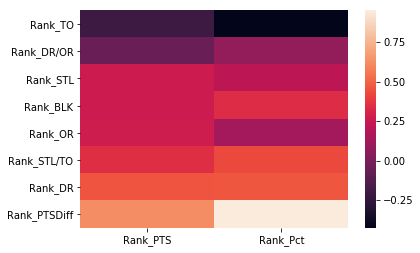

In [46]:
#Question: is there a good correlation between good defense teams and PTS (Points Per Game) and Pct
def_features = ['OR', 'DR/OR', 'TO', 'STL', 'STL/TO', 'BLK', 'PTSDiff', 'PTS', 'Pct']

def_df = partion_data(season_agg, 'DR')
for column in def_features:
    def_df = def_df.join(partion_data(season_agg, column), ['Season', 'TeamID', 'Name'], 'inner')
    def_df = def_df.drop(column)
    
# lets take a brief look at the teams with high
def_corr = def_df.drop('DR').orderBy(col('Season').desc()).toPandas().corr()
sns.heatmap(def_corr[["Rank_PTS", "Rank_Pct"]] \
            .iloc[:8].sort_values(["Rank_PTS", "Rank_Pct"]))
plt.show()

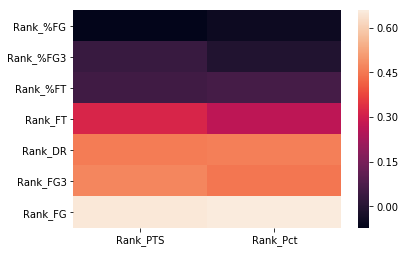

In [48]:
#Question: is there a good correlation between good offensive teams and PTS (Points Per Game) and Pct
off_features = ['FG', '%FG', 'FG3', '%FG3', 'FT', '%FT', 'PTSDiff', 'PTS', 'Pct']

off_df = partion_data(season_agg, 'DR')
for column in off_features:
    off_df = off_df.join(partion_data(season_agg, column), ['Season', 'TeamID', 'Name'], 'inner')
    off_df = off_df.drop(column)
    
# lets take a brief look at the teams with the hig
off_corr = off_df.drop('DR').orderBy(col('Season').desc()).toPandas().corr()
sns.heatmap(off_corr[["Rank_PTS", "Rank_Pct"]] \
            .iloc[:7].sort_values(["Rank_PTS", "Rank_Pct"]))
plt.show()

In [197]:
winner_detailed.columns

['Season', 'WTeamID', 'WScore', 'WLoc', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'Win_by', 'HomeWin', 'AwayWin', 'NeutralWin']

In [207]:
last_game_df = detailed_season.groupby('Season') \
                   .agg(max(col('DayNum')).cast(IntegerType()).alias('last_day')).orderBy(col('Season').desc())

# in order to capture momentum going into the game we will look at last two weeks stats
winner_momentum = \
    winner_detailed.filter(col('DayNum') > 118).groupby('Season', 'WTeamID') \
        .agg(sum(lit(1)).alias('NumWins'),
             round(sum(col('Win_by')), 1).alias('WinDiff'),
             round(sum(col('WScore')), 1).alias('WScore')) \
        .withColumnRenamed('WTeamID', 'TeamID')

kentucky_win = winner_detailed_season.filter(col('Season') == 2015) \
                    .filter(col('WTeamID') == 1246) \
                    .withColumn('NumTotal', col('NumWins')) \
                    .withColumn('PTS-14', round((col('WScore'))/col('NumTotal'), 2)) \
                    .withColumn('PTSDiff-14', round((col('WinDiff'))/col('NumTotal'), 2)) \
                    .withColumn('Pct-14', round(100*col('NumWins')/col('NumTotal'), 2)) \
                    .withColumnRenamed('WTeamID', 'TeamID') \
                    .select('TeamID', 'Season', 'PTS-14', 'PTSDiff-14', 'Pct-14')

# create loss features
loss_momentum = \
loss_detailed.filter(col('DayNum') > 118).groupby('Season', 'LTeamID') \
        .agg(sum(lit(1)).alias('NumLoss'),
             round(sum(col('Loss_by')), 1).alias('LossDiff'),
             round(sum(col('LScore')), 1).alias('LScore')) \
        .withColumnRenamed('LTeamID', 'TeamID')

#lets aggregate 
season_momentum = winner_momentum\
.join(loss_momentum, ['Season', 'TeamID'], 'inner') \
.withColumn('NumTotal', col('NumWins') + col('NumLoss')) \
.withColumn('PTS-14', round((col('WScore') + col('LScore'))/col('NumTotal'), 2)) \
.withColumn('PTSDiff-14', round((col('WinDiff') + col('LossDiff'))/col('NumTotal'), 2)) \
.withColumn('Pct-14', round(100*col('NumWins')/col('NumTotal'), 2)) \
.select('TeamID', 'Season', 'PTS-14', 'PTSDiff-14', 'Pct-14')

season_momentum = season_momentum.union(kentucky_win)
check_nulls(season_momentum)

Dataframe has no null values


In [208]:
# less add momentum features
season_agg = season_agg.join(season_momentum, ['Season', 'TeamID'], 'inner')

## Public Rankings

In [209]:
file_path = '../MarchMadness2021/data/MMasseyOrdinals.csv'
public_rankings = load_dataframe(file_path) 
public_rankings.limit(5).toPandas()

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260


In [210]:
#lets just the last ranking before day 1 of tournament
window = Window.partitionBy('Season', 'SystemName', 'TeamID') \
              .orderBy(col('RankingDayNum').cast(IntegerType()).desc())

rankings = public_rankings.withColumn('rank', row_number().over(window)) \
                          .filter(col('rank') == 1) \
                          .drop('rank') 

rankings = rankings.groupby('Season', 'TeamID') \
            .agg(sum(col('OrdinalRank')).alias('rank')
                 ,sum(lit(1)).alias('line_num')) \
             .withColumn('rank', floor(col('rank')/col('line_num'))) \
             .drop('line_num')
 
# There are 179 rankings!!!
# floor the average of these as ranking

In [211]:
# lets add ranking to season_Agg
season_agg = season_agg.join(rankings, ['Season', 'TeamID'], 'inner')

In [ ]:
#save data
season_agg.toPandas().to_csv('write_data/season_agg.csv', index=False)